## Deep Q-Learning

#### This tutorial assumes that you have completed reading the policy gradient notebook and have an understanding of Markov Decision Processes and policy gradient models. If not, please revisit them [here](../PolicyGradient/policygradient_discrete.ipynb) and [here](../PolicyGradient/policygradient_continuous.ipynb).

## Contents
1. What is Deep-Q learning?
2. Exploring its mathematical foundations.
3. Why use it?
4. How can we apply it to the Metadrive environment?

In the last notebook, you learned about policy gradients - a way to create powerful learners that update on the gradient of the objective function. 

As a refresher, here is the objective function again:

$J(\pi_{\theta}) = \sum_{\tau \in \mathcal{T}} R(\tau) \Pr(\tau|\pi_{\theta})$,

where $\sum_{\tau \in \mathcal{T}}$ represents trajectories in the set of possible trajectories and $\Pr(\tau|\pi_{\theta})$ represents the probability of the trajectory being taken under the current policy.

### V (value) and Q (quality)
As we dive into our exploration of Q-networks, it's useful to take a look at a key idea that will come up often later on: we can denote the *value* of a state (how good a position is) by denoting **value** and **quality** functions. 

More specifically, the **value** function represents the value of a **state** while the **quality** function represents the quality of a **state-action pair**. OpenAI's [Spinning Up on Deep RL](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#trajectories) has a great article on this, which we'll reiterate below:

> There are four main functions of note:
>
>The On-Policy Value Function, $V^{\pi}(s)$, which gives the expected return if you start in state s and always act according to policy $\pi$:
>
>$$V^{\pi}(s) = \underset{\tau \sim \pi}{\operatorname{E}}[{R(\tau)\left| s_0 = s\right.}]$$
>
>The On-Policy Action-Value Function, $Q^{\pi}(s,a)$, which gives the expected return if you start in state s, take an arbitrary action a (which may not have come from the policy), and then forever after act according to policy $\pi$:
>
>$$Q^{\pi}(s,a) = \underset{\tau \sim \pi}{\operatorname{E}}[{R(\tau)\left| s_0 = s, a_0 = a\right.}]$$
>
>The Optimal Value Function, $V^*(s)$, which gives the expected return if you start in state s and always act according to the optimal policy in the environment:
>
>$$V^*(s) = \max_{\pi} \underset{\tau \sim \pi}{\operatorname{E}}[{R(\tau)\left| s_0 = s\right.}]$$
>
>The Optimal Action-Value Function, $Q^*(s,a)$, which gives the expected return if you start in state s, take an arbitrary action a, and then forever after act according to the optimal policy in the environment:
>
>$$Q^*(s,a) = \max_{\pi} \underset{\tau \sim \pi}{\operatorname{E}}[{R(\tau)\left| s_0 = s, a_0 = a\right.}]$$

### DQL Paradigm

A policy function explicitly determines the action to take at each timestep by returning a distribution of likelihoods, where $\pi(s, a)$ is the likelihood of taking action $a$ at state $s$ given policy $\pi$. Q-learning ignores this step by instead predicting the *quality* of an action-state pair, where the quality is equal to the sum of the current reward and the time-discounted future reward.

$$Q^\pi(s_t, a_t) = E_\pi[\sum_{k=0}^\infty \gamma^k * r_{t+k+1} | s = s_t, a = a_t]$$

Don't worry if the equation above sounds complex, we'll break it down step by step. As in the policy gradient formulation, we're looking to maximize our total time-discounted (TD) return.

We have a quality function $Q^\pi(s_t, a_t)$ that estimates the value of a state-action pair given future actions that the current policy tends to take. As an aside, the $\pi$ in $Q^\pi(s_t, a_t)$ indicates that we're trying to represent the quality of a state-action pair under our current policy $\pi$. This is an important distinction to note, as $Q^\pi(s_t, a_t)$ changes as $\pi$ improves; in chess, a mate-in-five position that's down on material would be of great value to a grandmaster but useless to a novice.

We can explicitly break it down as the expected reward resulting from the state-action pair ($E_\pi[r_{t+1}]$) plus the time-discounted rewards from the future: 

$Q^\pi(s_t, a_t)$ = $E_\pi[r_{t+1}]$ + $E_\pi[\gamma * r_{t+2}]$ + $E_\pi[\gamma^2 * r_{t+3}]$ + $E_\pi[\gamma^3 * r_{t+4}]...$

Which we denote in summation form as the central equation above.

### Bellman Breakdown
The *Bellman Equation* is a recursive rewriting of the Q-value equation, and the formula that we'll be using to update our Q-model:
$$Q^\pi(s_t, a_t) = E_\pi[r_{t+1}] + \gamma * Q^\pi(s_{t+1}, a_{t+1})$$

This equation is pretty intuitive, but we can more rigorously derive the above formula from our definition of $Q^\pi(s_t, a_t)$. If you enjoy math, read on:

We establish our original Q-function by truncating the reward function to begin at timestep *t*. Intuitively, think of the Q-value (quality) of a state-action pair at timestep t as the expected return *if the environment had begun with the state we're currently in*. We can disregard the past as the environment has the [Markov property](https://en.wikipedia.org/wiki/Markov_property), which states that future states only depend on the present state. In other words, because the environment is a Markov process, the past does not matter - only the present does. Here's the time-delayed reward function:
$$R_{\gamma}(\tau) = \sum_{t=0}^T \gamma^t r_t$$

We derive the Q-function by denoting the expected value of time-delayed future rewards:

$$Q^\pi(s_t, a_t) = E_\pi[\sum_{k=0}^\infty \gamma^k * r_{t+k+1} | s = s_t, a = a_t]$$

### Recursive Property Derivation
$$Q^\pi(s_t, a_t) = E_\pi[\sum_{k=0}^\infty \gamma^k * r_{t+k+1} | s = s_t, a = a_t]$$
$$ = E_\pi[r_{t+1} + \gamma * \sum_{k=0}^\infty \gamma^k * r_{t+k+2} | s = s_{t}, a = a_{t}]$$
As expectation is distributive over addition:
$$ = E_\pi[r_{t+1}] + E_\pi[\gamma * \sum_{k=0}^\infty \gamma^k * r_{t+k+2} | s = s_{t+1}, a = a_{t+1}]$$

Using the definition of expectation:
$$
= \left( \sum_{a \in A} Pr_\pi(a | s_t) * \sum_{s' \in S} Pr(s'|s_t, a)\right) * r(s') + E_\pi[\sum_{k=0}^\infty \gamma^k * r_{t+k+2} | s = s_{t+1}, a = a_{t+1}]
$$

As review, $Pr_\pi(a | s_t)$ is the probability of our current policy taking action $a$ in state $s_t$. As we don't explicitly predict the likelihood of the action being taken, the value of $Pr_\pi(a | s_t)$ is unknown - which is why we're updating $Q^\pi(s, a)$ via monte-carlo sampling of the environment.

We add the term $Pr(s'|s_t, a)$ to allow for stochastic environments - where taking action A at state S can transition to many possible successor states $s' \in S$.

$$
\left( \sum_{a \in A} Pr_\pi(a | s_t) * \sum_{s' \in S} Pr(s'|s_t, a)\right) * r(s') = E[r_{t+1}]
$$
$$
\gamma E_\pi[\sum_{k=0}^\infty \gamma^k * r_{t+k+2} | s = s_{t+1}, a = a_{t+1}] = \gamma * Q^\pi(s_{t+1}, a_{t+1})
$$

$$
Q^\pi(s_t, a_t) = E[r_{t+1}] + \gamma * Q^\pi(s_{t+1}, a_{t+1})
$$

Which is the same equation we started with.

### Updating values
Let's say our agent is dropped in an environment and we're looking to learn a robust and accurate Q-function. 

More specifically, we're looking to find $Q^{\pi^*}(s_t, a_t)$, which is the *optimal quality function* that denotes the quality of each state-action pair under the optimal policy $\pi^*(a|s)$. We can update our Q-function by doing Monte-Carlo sampling from our environment. Under our policy (let's not worry about how to decide which actions to take just yet), we gather trajectories from the environment and update our Q-value function as so:

If the current step isn't the last step:
$$Q^{\pi}(s_t, a_t) \leftarrow \left(r_{t+1} + \underset{a \in A}{\operatorname{argmax}} Q^{\pi}(s_{t+1}, a) \right)$$
If the current step is the last step:
$$Q^{\pi}(s_t, a_t) \leftarrow r_{t+1}$$

As we gather more samples, we can optimize Q by using mean squared error or a similar loss metric to minimize the distance between Q and its target.

### A decision policy
Given the quality function $Q^\pi(s_t, a_t)$, there are a variety of strategies we can use to select our actions. One is always taking the action that we believe has the highest quality:
$$\pi(s_t, a_t) = \underset{a \in A}{\operatorname{argmax}} \space Q^\pi(s_t, a)$$ 

Would this be effective? Take a second to think before looking at the next block.

Text(8, 16, 'end')

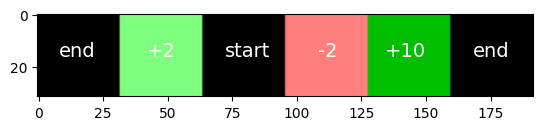

In [36]:
import matplotlib.pyplot as plt
import numpy as np
red, green, light_green, black = np.zeros((4, 32, 32, 3))
red += np.array([1, 0.5, 0.5])
green += np.array([0, 0.75, 0])
light_green += np.array([0.5,1,0.5])
plt.imshow(np.concatenate([black, light_green, black, red, green, black], axis=1))
plt.text(42, 16, '+2', color='white', fontsize=14)
plt.text(108, 16, '-2', color='white', fontsize=14)
plt.text(134, 16, '+10', color='white', fontsize=14)
plt.text(72, 16, 'start', color='white', fontsize=14)
plt.text(168, 16, 'end', color='white', fontsize=14)
plt.text(8, 16, 'end', color='white', fontsize=14)

Before we gather any samples about the environment, the model is equally likely to explore either the +2 square and the -2 square. Let's imagine it explores the +2 square before ending the episode; after updating at the end of the episode, the model learns to always seek out the +2 square, never being able to reach the +10 square (with each update afterward only confirming its bias). Clearly, we need to add a term for exploration:

### Epsilon-Greedy
$$
\pi(s_t, a_t) = 
\begin{array}{lr}
        \text{if rand()} \geq \epsilon& \underset{a \in A}{\operatorname{argmax}} \space Q^\pi(s_t, a),\\
        \text{else} & {a \in_R A} 
\end{array}
$$

We set $\epsilon$ to a high value (~0.3) at the start of training and slowly reduce it as the model explores more strategies.

Sidenote: Our entirely greedy policy works well for post-training inference, because: $$\pi^*(s_t, a_t) = \argmax_{a \in A} Q^{\pi^*}(s_t, a)$$ You can retrieve the greedy policy by setting $\epsilon$ to 0. 

### Why use Q-learning?

Policy gradient learners are algorithmically elegant and stable learners. Why would we use a state-action value estimator instead of defining a policy directly?

A few key downsides of policy gradient networks are:
- Sample inefficiency: to accurately estimate the gradient via Monte-Carlo methods, the model needs to run over many episodes on the environment. Policy-gradient methods typically require many times more training samples than other methods. You probably observed that the REINFORCE algorithm took many episodes just to learn to consistently drive forwards on the Metadrive environment! While this is alleviated with more advanced algorithms like Proximal Policy Optimization (PPO) (which we'll explore later), Deep-Q learning inherently bypasses the sample inefficiency of policy gradient methods. This is because Q-learning methods can take advantage of off-policy learning and replay buffers to continue to learn from its past mistakes, as the value of a state-action pair stays relatively constant as the agent learns (in the short term), making it feasible to have the same trajectory in the replay buffer for multiple epochs and update on it many times.

- Exploration-exploitation trade-off: To learn in any environment, an agent will need to explore (to sample from diverse environmental states) and exploit (focus on high-reward strategies). To improve at chess, we might play our best moves most of the time, but also throw in a few questionable moves to test them out and broaden our strategic choices. Policy gradient methods can get stuck in local optimal due to insufficient exploration. In Deep-Q learning, we explicitly set a parameter that sets the balance between exploration and exploitation.

Q-learning has flaws as well:
- Lack of stability. The *moving target problem* occurs:
$$Q^{\pi}(s_t, a_t) \leftarrow \left(r_{t+1} + \argmax_{a \in A} Q^{\pi}(s_{t+1}, a) \right)$$
Observe how this not only updates $Q^{\pi}(s_t, a_t)$ but also implicitly updates $\pi(s_t, a_t)$. When we update our value function, the behavior of our policy shifts, which changes the true value of the moves we're taking. This makes training unstable by default. Double and dueling DQNs alleviate this problem, and we'll talk about them in the next notebook.
- Difficulties with continuous environments: the above update rule also only works in discretized environments, as $\argmax_{a \in A} Q^{\pi}(s_{t+1}, a)$ is intractable to calculate if there are infinite possible actions.

### You try it!

As before, we have two notebooks - one with exercises, the other with solutions. We recommend that you try the first notebook first, and then use the second notebook as a reference if you get stuck.
* [Policy Gradient Discrete Exercise](dqn_solutions.ipynb)
* [Policy Gradient Discrete Solution](dqn_exercise.ipynb)

Before completing the second half of the exercises, be sure to check out the explanations behind [Double and Dueling DQNs](double_and_dueling.ipynb).

### Additional Readings
This tutorial was based on a few source documents. If you're interested, you can check them out below:
1. [Value Iteration vs Policy Iteration](https://www.baeldung.com/cs/ml-value-iteration-vs-policy-iteration)
2. [A mathematical introduction to Reinforcement Learning, CMU](https://www.cs.cmu.edu/~mgormley/courses/10601-s17/slides/lecture26-ri.pdf)